<a href="https://colab.research.google.com/github/PikoAll/Colab/blob/main/AIRaggiXDatiSplittati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI per riconoscere polmonite
kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
# tutti gli import

import os
import shutil
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPool2D, BatchNormalization, MaxPooling2D   ############################# o 3D
from tensorflow.keras.regularizers import l2 
import tensorflow
from sklearn.metrics import confusion_matrix

In [2]:
#Costanti
DIM=(224,224)

In [3]:
os.mkdir("Dataset")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#copio la caretella qua
shutil.copy("/content/drive/MyDrive/Dataset/RaggiXPolmonite.zip","/content/Dataset/")

'/content/Dataset/RaggiXPolmonite.zip'

Estrazione da file zip

In [6]:
# apertura dell'archivio per estrazione
archivio = zipfile.ZipFile('/content/Dataset/RaggiXPolmonite.zip')

# estrazione di tutti i file
archivio.extractall("/content/Dataset/")  #percorso dove estrerre i file

# chiusura
archivio.close()

In [7]:
os.chdir("/content/Dataset/chest_xray/")  #per cambiare cartella
print(os.listdir())

['train', 'val', 'test', 'chest_xray', '__MACOSX']


Carico le img e li processo

In [8]:
X_test=[]
X_train=[]

y_test=[]
y_train=[]

X_val=[]
y_val=[]

cartelle=['test','val','train']
#cartelle=['val','train']

for i in cartelle:

  for j in os.listdir("/content/Dataset/chest_xray/"+i+"/"):
    
    for z in os.listdir("/content/Dataset/chest_xray/"+i+"/"+j+"/"):
      
      img=cv2.imread("/content/Dataset/chest_xray/"+i+"/"+j+"/"+z)
      img=cv2.resize(img,DIM,interpolation=cv2.INTER_NEAREST)/255     #ridimensinamento immaggine  il /255 normalizza i pixel  (100,100)
      
      #X.append(img)
      #y.append(j)
      
      if i==cartelle[0]:
        X_test.append(img)
        y_test.append(j)

      elif i==cartelle[1]:
        X_val.append(img)
        y_val.append(j)
      else:
        X_train.append(img)
        y_train.append(j)
      

X_train=np.array(X_train)
y_train=np.array(y_train) 

X_test=np.array(X_test)
y_test=np.array(y_test)

X_val=np.array(X_val)
y_val=np.array(y_val) 

print("Train X ",X_train.shape," y ", y_train.shape)
print("Test X ",X_test.shape," y ", y_test.shape)
print("Validazione X ",X_val.shape," y ", y_val.shape)


Train X  (5216, 224, 224, 3)  y  (5216,)
Test X  (624, 224, 224, 3)  y  (624,)
Validazione X  (16, 224, 224, 3)  y  (16,)


In [9]:
def show_exaple(x):
  fig=plt.figure()

  for i in range(x.shape[0]):
    plot=fig.add_subplot(1,x.shape[0], i+1)
    plt.imshow(X_train[i])
    plt.axis("off")

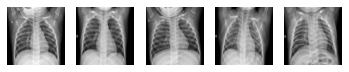

In [10]:
show_exaple(X_train[:5])  # gli ho passato solo le prime 5 immaggini di X

To categorical

In [11]:
#Y=[]
Y_test=[]
Y_train=[]
Y_val=[]


for i in y_test:
  if i=="NORMAL":
    Y_test.append(0)
  elif i=="PNEUMONIA":
    Y_test.append(1)

for i in y_train:
  if i=="NORMAL":
    Y_train.append(0)
  elif i=="PNEUMONIA":
    Y_train.append(1)

for i in y_val:
  if i=="NORMAL":
    Y_val.append(0)
  elif i=="PNEUMONIA":
    Y_val.append(1)


Y_test=to_categorical(Y_test)
Y_train=to_categorical(Y_train)
Y_val=to_categorical(Y_val)



print("Train X ",X_train.shape," y ", Y_train.shape)
print("Test X ",X_test.shape," y ", Y_test.shape)
print("Validazione X ",X_val.shape," y ", Y_val.shape)

Train X  (5216, 224, 224, 3)  y  (5216, 2)
Test X  (624, 224, 224, 3)  y  (624, 2)
Validazione X  (16, 224, 224, 3)  y  (16, 2)


In [12]:
from tensorflow.keras import backend as K
K.clear_session()
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                5972000   
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [15]:
print("X train ", X_train.shape)
print("X test ", X_test.shape)
print("y train ", y_train.shape)
print("y test ", y_test.shape)


model.compile(loss=tensorflow.keras.losses.binary_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(0.01), metrics=["accuracy","AUC"]) #SparseCategoricalCrossentropy()
#model.compile(loss=tensorflow.keras.losses.binary_crossentropy, optimizer=tensorflow.keras.optimizers.SGD(0.01), metrics=["accuracy","AUC"]) #SparseCategoricalCrossentropy()
#model.compile(loss='binary_crossentropy',               optimizer='adam',               metrics=['accuracy'])
model.fit(X_train,Y_train,validation_data=(X_val,Y_val),validation_split=0.1, epochs=20)

X train  (5216, 224, 224, 3)
X test  (624, 224, 224, 3)
y train  (5216,)
y test  (624,)
Epoch 1/20
147/147 [==============================] - 24s 45ms/step - loss: 3.1319 - accuracy: 0.7203 - auc: 0.7987 - val_loss: 0.4782 - val_accuracy: 0.9464 - val_auc: 0.9899
Epoch 2/20
147/147 [==============================] - 6s 38ms/step - loss: 0.8454 - accuracy: 0.7693 - auc: 0.8728 - val_loss: 0.4321 - val_accuracy: 0.9138 - val_auc: 0.9901
Epoch 3/20
147/147 [==============================] - 6s 38ms/step - loss: 0.6018 - accuracy: 0.8123 - auc: 0.8988 - val_loss: 0.3667 - val_accuracy: 0.8870 - val_auc: 0.9829
Epoch 4/20
147/147 [==============================] - 5s 37ms/step - loss: 0.6277 - accuracy: 0.8155 - auc: 0.9031 - val_loss: 0.5352 - val_accuracy: 0.7912 - val_auc: 0.9267
Epoch 5/20
147/147 [==============================] - 6s 38ms/step - loss: 0.6176 - accuracy: 0.8277 - auc: 0.9115 - val_loss: 0.4216 - val_accuracy: 0.8448 - val_auc: 0.9672
Epoch 6/20
147/147 [================

In [16]:
metrics_train=model.evaluate(X_train,Y_train)
metrics_test=model.evaluate(X_test,Y_test)
print("Train accuracy ",metrics_train[1])
print("Test accuracy ",metrics_test[1])


20/20 [==============================] - 0s 22ms/step - loss: 1.0565 - accuracy: 0.8462 - auc: 0.8969
Train accuracy  0.9008818864822388
Test accuracy  0.8461538553237915


In [17]:
pred=model.predict(X_test)
pred=np.argmax(pred,axis=1)
yy=np.argmax(Y_test,axis=1)
cm= confusion_matrix(yy,pred)
cm

array([[175,  59],
       [ 37, 353]])